In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from iminuit import Minuit    
from scipy import stats
import seaborn as sns
sns.set()
sns.set_palette("husl",8)

import sys
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax

# Define functions

In [2]:
"""Function for linear plot"""

def lin_func(x,a,b):
    return a*x+b

In [3]:
"""Function for Gaussian pdf"""

def gauss_pdf(x, N, mu, sigma):
    return N / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

In [4]:
"""Function to compute binwidth for histograms from Freedman-Diaconis rule"""

def bin_width(data):
    return 2*stats.iqr(data)*len(data)**(-1/3)

In [5]:
"""Function to compute root mean square deviation"""

def RMSD(data):
    return np.sqrt(np.sum((data-data.mean())**2)/(len(data)-1))

In [6]:
"""Function to compute chi2 and p value"""

def chi2(data, exp, errors):
    chi_2 = np.sum(((data-exp)/errors)**2)
    dof = len(data)
    p = 1 - stats.chi2.cdf(chi_2, dof)
    return chi_2, p

In [7]:
"""Function to perform weighted average"""

def weighted_average(data, errors):
    avg = np.sum(data/errors**2)/np.sum(1/errors**2)
    err = np.sqrt(1/np.sum(1/errors**2))
    exp = avg*np.ones(len(data))
    chi_2, p = chi2(data, exp, errors)
    return avg, err, chi_2, p

In [8]:
"""Function to fit residuals to a Gaussian"""

def fit_residuals(data, minL, maxL, plot=bool):
    binwidth = bin_width(data)
    Nbins = round((maxL-minL)/binwidth)

    ullh = UnbinnedLH(gauss_pdf, data, extended=True)
    minuit = Minuit(ullh, N=len(data)*binwidth, mu=data.mean(), sigma=data.std(ddof=1))
    minuit.print_level = 1
    minuit.errordef = 0.5
    minuit.migrad();
    
    chi2_val = minuit.fval
    N_DOF = len(data) - len(minuit.values[:])
    chi2_prob = stats.chi2.sf(chi2_val, N_DOF)

    fit_sigma = minuit.values["sigma"]
    fit_mu = minuit.values["mu"]
    fit_mu_error = minuit.errors["mu"]
    
    if plot:
        d = {'mu:': [fit_mu, fit_mu_error], 'sigma:':fit_sigma}
        text = nice_string_output(d, extra_spacing=2, decimals=3)

        xaxis = np.linspace(minL, maxL, 10000) 
        yaxis = gauss_pdf(xaxis, len(data)*binwidth, fit_mu, fit_sigma) 

        fig, ax = plt.subplots(figsize=(8,5))
        ax.hist(data, bins=Nbins, range=(minL, maxL), histtype='stepfilled', label='Data');
        ax.plot(xaxis, yaxis, '-', label='Fit by Minuit')
        add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)
        ax.legend(loc='upper left')
        fig.tight_layout()
    
#     return fit_sigma, chi2_val, chi2_prob
    return fit_sigma

In [9]:
"""Function to fit time data with uncertainty from time residuals"""

def fit_linear(x, y, y_err, a_init, b_init, plot=bool):
    chi2_object = Chi2Regression(lin_func, x, y, y_err)
    chi2_object.errordef = Minuit.LEAST_SQUARES
    minuit = Minuit(chi2_object, a=a_init, b=b_init)
    minuit.migrad();
    a, b = minuit.values[:]

    chi2_val = minuit.fval
    N_DOF = len(x) - len(minuit.values[:])
    chi2_prob = stats.chi2.sf(chi2_val, N_DOF)
    
    if plot:
        x_fit = np.linspace(0, 30, 1000)
        y_fit = lin_func(x_fit, a, b)

        d = {'Entries':  len(x),
         'Chi2':     chi2_val,
         'ndf':      N_DOF,
         'Prob':     chi2_prob}

        #add fit parameters to text box
        for name in minuit.parameters:
            d[name] = [minuit.values[name], minuit.errors[name]]

        text = nice_string_output(d, extra_spacing=2, decimals=3)

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.errorbar(x, y, yerr=y_err, fmt='ko', label = 'Data')
        ax.plot(x_fit, y_fit, '-', label='Fit by Minuit')
        ax.set(title="Linear fit by Minuit", 
            xlabel="Index", 
            ylabel="Time (s)");
        add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)
        ax.legend(loc='lower right')
        fig.tight_layout()
        
    return minuit.values['a'], minuit.errors['a'], chi2_val, chi2_prob

# Treating and plotting the data (example)

In [10]:
#import data
amalie = np.genfromtxt('amalie.dat', delimiter='\t', names=('n', 't_s'))
n, t = amalie['n'][1:-1], amalie['t_s'][1:-1]

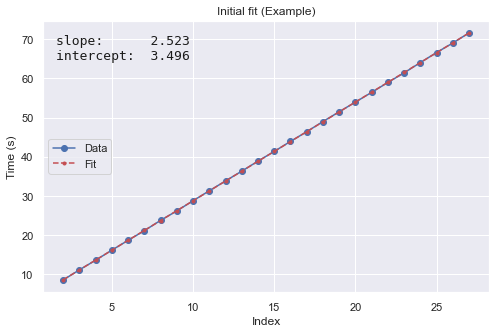

In [11]:
#plot data with initial fit
reg = LinearRegression().fit(n.reshape(-1,1),t.reshape(-1,1))
fit_times = (n*reg.coef_+reg.intercept_).reshape(len(n),) 

d = {'slope:': reg.coef_[0,0], 'intercept:':reg.intercept_[0]}
text = nice_string_output(d, extra_spacing=2, decimals=3)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(n,t,'bo-', label='Data')
ax.plot(n,fit_times,'r.--', label='Fit')
add_text_to_ax(0.03, 0.95, text, ax, fontsize=13)
ax.legend(loc='center left')
ax.set_xlabel('Index')
ax.set_ylabel('Time (s)')
ax.set_title('Initial fit (Example)');

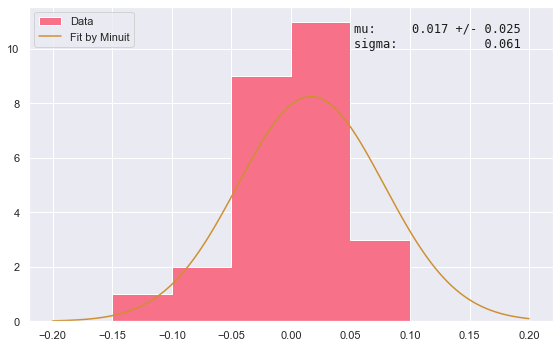

In [12]:
#compute residuals and fit to Gaussian
res = t-fit_times
# sigma, res_chi2, res_p = fit_residuals(res, -0.2, 0.2, plot=True)
sigma = fit_residuals(res, -0.2, 0.2, plot=True)

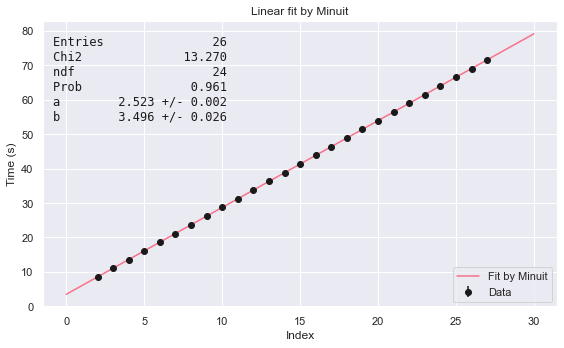

In [13]:
#linear fit with input error from residual fit
a_init, b_init = reg.coef_[0,0], reg.intercept_[0]
t_err = np.ones(len(t))*sigma
slope, slope_err, slope_chi2, slope_p = fit_linear(n, t, t_err, a_init, b_init, plot=True)

# Get period from all 5 measurements

In [14]:
#treat all 5 data sets
period = []
period_err = []
period_chi2 = []
period_p = []
sigmas = []
residuals = []
names = ['amalie', 'soren', 'sara', 'lukas', 'elloise']

for name in names:
    file_name = name+'.dat'
    file = np.genfromtxt(file_name, delimiter='\t', names=('n', 't_s'))
    n, t = file['n'][1:-1], file['t_s'][1:-1] #exclude first and last data point
    
    #perform initial linear regression
    reg = LinearRegression().fit(n.reshape(-1,1),t.reshape(-1,1))
    fit_times = (n*reg.coef_+reg.intercept_).reshape(len(n),)
    
    #compute time residuals
    res = t-fit_times
    residuals.append(res)
    
    #fit residuals to Gaussian and get sigma
#     sigma, res_chi2, res_p = fit_residuals(res, -0.2, 0.2, plot=False)
    sigma = fit_residuals(res, -0.2, 0.2, plot=False)
    sigmas.append(sigma)
    
    #perform linear fit by Minuit with error from Gaussian sigma
    a_init, b_init = reg.coef_[0,0], reg.intercept_[0]
    t_err = np.ones(len(t))*sigma
    slope, slope_err, slope_chi2, slope_p = fit_linear(n, t, t_err, a_init, b_init, plot=False)
    
    #add slope and error to list
    period.append(slope)
    period_err.append(slope_err)
    period_chi2.append(slope_chi2)
    period_p.append(slope_p)

W VariableMetricBuilder No improvement in line search


In [22]:
#show in dataframe
df = pd.DataFrame({'Period (s)': period,
                   'Error (s)': period_err,
                   'Chi2': period_chi2,
                   'P-value': period_p,
                   'Time resolution (s)': sigmas},
                  index=['Amalie', 'Søren', 'Sara', 'Lukas', 'Elloise'])

df

,Period (s),Error (s),Chi2,P-value,Time resolution (s)
Amalie,2.522592,0.001607,13.269983,0.961460,0.061461
Søren,2.518794,0.000939,22.718650,0.536454,0.035919
Sara,2.514937,0.000584,21.061314,0.577343,0.021048
Lukas,2.518783,0.001937,10.238081,0.993493,0.074068
Elloise,2.510356,0.003412,7.677334,0.998829,0.123038


In [31]:
#print residuals
print('Residuals:')
for i,n in zip(names, residuals):
    print(str(i),': ',str(n.round(4)))

Residuals:
amalie :  [-4.840e-02  2.120e-02 -3.930e-02  1.200e-02 -1.500e-03 -6.800e-02
  5.270e-02 -5.910e-02  2.070e-02  3.530e-02  3.480e-02  1.020e-02
  5.340e-02 -1.000e-04  4.430e-02 -7.900e-03  7.290e-02  4.090e-02
 -5.300e-03 -4.510e-02 -3.100e-02 -1.123e-01  3.500e-03  3.920e-02
 -4.650e-02  2.340e-02]
soren :  [ 0.0017 -0.0049 -0.017   0.0238 -0.0091  0.0138  0.0158 -0.0914  0.0779
 -0.0444  0.0056  0.027   0.0432 -0.0177  0.0038 -0.012  -0.001   0.0076
 -0.0144 -0.0339 -0.007   0.0018  0.0567 -0.0375  0.0393 -0.0279]
sara :  [-0.0353 -0.0042  0.0239 -0.0004 -0.0421  0.0138  0.0203  0.054   0.0148
 -0.0141  0.0138 -0.0156 -0.0034  0.0038 -0.0127 -0.0048  0.0157 -0.0178
 -0.0042 -0.0089 -0.011  -0.0109  0.0085  0.0047  0.0121]
lukas :  [ 0.0358 -0.0363 -0.0483 -0.0178  0.0146 -0.0485  0.0576  0.0715  0.0033
  0.0262 -0.0133 -0.0476 -0.0476  0.0748  0.0268 -0.0617  0.0242  0.0273
 -0.0543  0.0643  0.04   -0.1106 -0.0165  0.0308 -0.0186  0.0238]
elloise :  [-0.0705 -0.0407 -0.03

# Combine period values

In [16]:
#weighted mean of period values
periods = np.array(period)
periods_err = np.array(period_err)
period_avg, period_avg_err, period_avg_chi2, period_avg_p = weighted_average(periods, periods_err)
print(f"  Weighted average of periods: {period_avg:.5f} +/- {period_avg_err:.5f} s, Chi2: {period_avg_chi2:.5f}, p: {period_avg_p:.5f}")

  Weighted average of periods: 2.51659 +/- 0.00046 s, Chi2: 32.09378, p: 0.00001


In [17]:
#add systematic error instead
diffs = []
for i in range(len(periods)):
    for n in range(len(periods)):
        diffs.append(periods_err[i]-periods_err[n])

diff = np.abs(np.array(diffs))

period_avg, period_avg_err, period_avg_chi2, period_avg_p = weighted_average(periods, periods_err+diff.max())
print(f"  Weighted average of periods: {period_avg:.5f} +/- {period_avg_err:.5f} s, Chi2: {period_avg_chi2:.5f}, p: {period_avg_p:.5f}")

  Weighted average of periods: 2.51751 +/- 0.00190 s, Chi2: 3.38289, p: 0.64118


# Combine string length measurements

In [18]:
#load and average string length measurements
snor = np.genfromtxt('snor.dat', delimiter=',', names=('string', 'string_err', 'ball', 'ball_err'))
string, string_err, ball, ball_err = snor['string'], snor['string_err'], snor['ball'], snor['ball_err']

string_len = string+(1/2)*ball
string_len_err = np.sqrt(string_err**2+(1/4)*ball_err**2)

string_avg, string_avg_err, string_avg_chi2, string_avg_p = weighted_average(string_len, string_len_err)
print(f"  Weighted average of string lenghts: {string_avg:.5f} +/- {string_avg_err:.5f} m, Chi2: {string_avg_chi2:.5f}, p: {string_avg_p:.5f}")

  Weighted average of string lenghts: 1.57396 +/- 0.00022 m, Chi2: 208.36905, p: 0.00000


In [19]:
#use arithmetic mean and RMSD instead
string_avg, string_avg_err, string_avg_chi2, string_avg_p = weighted_average(string_len, np.ones(len(string_len))*RMSD(string_len))
print(f"  Weighted average of string lenghts: {string_avg:.5f} +/- {string_avg_err:.5f} m, Chi2: {string_avg_chi2:.5f}, p: {string_avg_p:.5f}")

  Weighted average of string lenghts: 1.57674 +/- 0.00161 m, Chi2: 4.00000, p: 0.54942


# Combine everything

In [20]:
#combine period and string length
final_g = string_avg*(2*np.pi/period_avg)**2

#compute impacts on error on g
string_imp = (2*np.pi/period_avg)**4 * string_avg_err**2
period_imp = ((-2*string_avg*(2*np.pi)**2)/period_avg**3)**2 * period_avg_err**2

#compute final error on g
final_g_err = np.sqrt(string_imp+period_imp)

print(f" Final g: {final_g:.5f} +/- {final_g_err:.5f}")

 Final g: 9.82149 +/- 0.01789
